# CISC/CMPE 452/COGS 400 Assignment 2 - Backpropagation (15 points)  

Please put your name and student id here

    FirstName LastName, #12345678

- The notebook file has clearly marked blocks where you are expected to write code. Do not write or modify any code outside of these blocks.
- Make sure to restart and run all the cells from the beginning before submission. Do not clear out the outputs. You will only get credit for code that has been run.
- Mark will be deducted based on late policy (-1% of the course total marks per day after due date until the end date after which no assignments will be accepted)


## [Part 1 (9 points)](#Part-1)  

### Build Model1 (7 points)  
Use Pytorch to implement a three-layer Neural Network (input layer - hidden layer - output layer) and update the weights with backpropagation  
- 1. Implement forward and calculate the output (1 point)  
- 2. Calculate errors and loss (3 points)  
- 3. Update the weights with backpropagation (1 points)  
- 4. Predict function (1 point)  
- 5. Activation function (Sigmoid function) (1 point)  

### Evaluator Function (1 point)  
Implement the evaluator function with Pytorch or Numpy only   
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Train and Evaluate Model1 (1 point)  
Train Model1 with customized hidden size, learning rate, number of iterations and batch size  
Use the predict function to predict the labels with the test dataset  
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

## [Part 2 (6 points)](#Part-2)  

Use another machine learning framework (**scikit-learn, Tensorflow and Pytorch**) to build MLP
e.g. 
  1. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
  2. https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
  3. https://pytorch.org/tutorials/beginner/examples_nn/polynomial_nn.html#sphx-glr-beginner-examples-nn-polynomial-nn-py
  
### Build Model2-1 (2 points)  
Implement Model2-1 with the same hidden nodes and optimization function as the model in Part 1  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Train and Evaluate Model2-1 (1 point)
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Build Model2-2 (2 points)  
Add one more hidden layer (2 hidden layers in total) to the model  
Describe Model2-2 (number of hidden nodes)  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Train and Evaluate Model2-2 (1 point)
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

In [2]:
# you can go to Edit - Notebook settings to select GPU under the Hardware accelerator
# check the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# build the dataset (train, validation and test)
def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test
    return data_dict

In [4]:
# you can start with a small sample dataset by setting sample=True
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


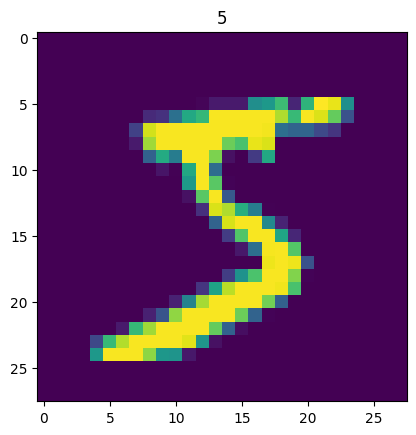

In [5]:
# plot an example
plt.imshow(data_dict['x_train'][0].reshape(28, 28))
plt.title(data_dict['y_train'][0].argmax().item())
plt.show()

In [6]:
def evaluator(y_test, y_pred):
    ####################################################################################################
    # enter code here to implement the evaluation metrics including confusion matrix, accuracy, precision and recall
    # you can only use Numpy or Pytorch to implement the metrics
    CM = torch.zeros(10, 10, dtype=torch.float32, device='cpu')
    Stats = torch.zeros(10, 4, dtype=torch.float32, device='cpu')
    y_test = torch.argmax(y_test, dim=1)
    
    for num, y_curr in enumerate(y_pred):
        CM[y_test[num], y_pred[num]] += 1
    i = 0
    while i < 10:
        #recall TP/(TP+FN)
        Stats[i, 0] = CM[i, i]/torch.sum(CM[i,:])
        #precision TP/(TP+FP)
        Stats[i, 1] = CM[i, i]/torch.sum(CM[:,i])
        #accuracy (TP+TN)/len(y_test)
        Stats[i, 2] = (CM[i, i]+torch.sum(CM)-torch.sum(CM[i,:]))/torch.sum(CM)
        #F_Measure = (2*Recall*Precision)/(Recall+Precision)
        Stats[i, 3] = (2*Stats[i, 0]*Stats[i, 1])/(Stats[i, 0]+Stats[i, 1])
        i += 1
    CM = CM.detach().cpu().numpy()
    Stats = Stats.detach().cpu().numpy()
    np.set_printoptions(suppress=True)
    print('10x10 confusion matrix, ActualxPredicted for the outputs 0-9:')
    print(CM)
    print('Stats for each 0-9 output in increasing order:')
    print('Recall      Precision     Accuracy    F1-Score')
    print(Stats)

####################################################################################################

## Part 1

In [7]:
class NN(object):
    def __init__(self, learning_rate, n_iters, batch_size, hidden_size, device, dtype=torch.float32):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
    
    # 5. activation function
    def sigmoid(self, x):
        ####################################################################################################
        # enter code here to implement the activation function

        sig = (1/(1+np.exp(-x)))

        return sig
        
        ####################################################################################################

    def train(self, x, y, x_val, y_val, verbose=1):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]
        
        # weight initialization
        self.W1 = torch.randn(input_size, self.hidden_size, dtype=self.dtype, device=self.device) * 0.01
        self.W2 = torch.randn(self.hidden_size, num_classes, dtype=self.dtype, device=self.device) * 0.01

        # TODO: train the weights with the input data and labels
        for i in range(self.n_iters):
            loss = 0
            data = getBatch(x, y, self.batch_size)
            for x_batch, y_batch in data:
                # 1. forward
                ####################################################################################################
                # enter code here to calculate the hidden layer output and output layer output
                hidden = self.sigmoid(x_batch.mm(self.W1))
                output = self.sigmoid(hidden.mm(self.W2))
                
                ####################################################################################################

                # 2. error and loss
                ####################################################################################################
                # enter code here to calculate the output error, MSE loss, delta output and delta hidden

                output_error = output - y_batch
                if output_error.shape[0] != 0:
                    loss += 0.5 * torch.mean(output_error ** 2)

                delta_output = output_error * output * (1 - output)
                delta_hidden = delta_output.mm(self.W2.t()) * hidden * (1 - hidden)

                ####################################################################################################

                # 3. backward
                ####################################################################################################
                # enter code here to calculate delta weights and update the weights
                self.W2 -= self.learning_rate * hidden.t().mm(delta_output)
                self.W1 -= self.learning_rate * x_batch.t().mm(delta_hidden)
                ####################################################################################################

            # calculate the accuracy and save the training history
            y_pred = self.predict(x)
            train_acc = torch.sum(torch.argmax(y, dim=1) == y_pred) / n_train
            self.history['train_acc'].append(train_acc)
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            val_acc = torch.sum(torch.argmax(y_val, dim=1) == y_pred) / n_val
            self.history['val_acc'].append(val_acc)
            
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                  % (i + 1, loss, train_acc, val_acc))
    
    # 4. predict function 
    def predict(self, x):
        ####################################################################################################
        # enter code here to implement the predict function
        # TODO: use the trained weights to predict labels and return the predicted labels
        # remember to use torch.argmax() to return the true labels
        y_hid = torch.zeros(self.hidden_size, dtype=self.dtype, device=self.device)
        y_pred = torch.zeros(x.shape[0],10, dtype=self.dtype, device=self.device)
        for num, x_curr in enumerate(x):
            y_hid = self.sigmoid(np.matmul(x_curr,self.W1))
            y_pred[num] = self.sigmoid(np.matmul(y_hid,self.W2))
        y_pred = torch.argmax(y_pred, dim = 1)
        
        ####################################################################################################
        return y_pred

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]    
    yield x_batch, y_batch

In [8]:
####################################################################################################
# enter code here to train Model1
# TODO: set your desired hidden size, learning rate, number of iterations and batch size
# remeber to load the dataset to the device (e.g. data_dict['x_train'].to(device))
learning_rate = 0.01
epochs = 100
batch_size = 100
hidden_size = 128

device = 'cpu'
Model1 = NN(learning_rate, epochs, batch_size, hidden_size, device)
Model1.train(data_dict['x_train'], data_dict['y_train'], data_dict['x_val'], data_dict['y_val'])

####################################################################################################

epoch 1, loss 17.3180, train acc 0.820, validation acc 0.840
epoch 2, loss 6.9501, train acc 0.890, validation acc 0.902
epoch 3, loss 4.9467, train acc 0.904, validation acc 0.914
epoch 4, loss 4.2429, train acc 0.912, validation acc 0.922
epoch 5, loss 3.8321, train acc 0.919, validation acc 0.925
epoch 6, loss 3.5405, train acc 0.923, validation acc 0.929
epoch 7, loss 3.3126, train acc 0.928, validation acc 0.934
epoch 8, loss 3.1239, train acc 0.932, validation acc 0.937
epoch 9, loss 2.9619, train acc 0.935, validation acc 0.940
epoch 10, loss 2.8200, train acc 0.938, validation acc 0.943
epoch 11, loss 2.6937, train acc 0.941, validation acc 0.946
epoch 12, loss 2.5798, train acc 0.943, validation acc 0.949
epoch 13, loss 2.4761, train acc 0.946, validation acc 0.951
epoch 14, loss 2.3808, train acc 0.948, validation acc 0.952
epoch 15, loss 2.2926, train acc 0.950, validation acc 0.954
epoch 16, loss 2.2105, train acc 0.952, validation acc 0.956
epoch 17, loss 2.1340, train acc

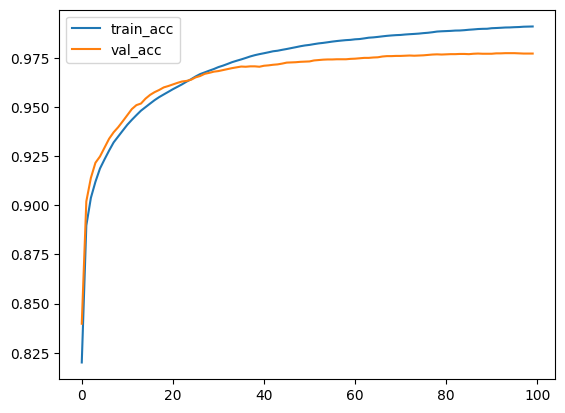

In [9]:
plt.plot(Model1.history['train_acc'], label='train_acc')
plt.plot(Model1.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [10]:
####################################################################################################
# enter code here to evaluate Model1 with test set
# TODO: use the trained Model1 to predict the labels of test set and evaluate the results with the evaluator
y_test_pred = Model1.predict(data_dict['x_test'])
evaluator(data_dict['y_test'], y_test_pred)

####################################################################################################

10x10 confusion matrix, ActualxPredicted for the outputs 0-9:
[[ 968.    0.    3.    1.    0.    2.    2.    1.    2.    1.]
 [   0. 1122.    2.    1.    0.    1.    4.    1.    4.    0.]
 [   1.    1. 1012.    2.    1.    0.    2.    7.    6.    0.]
 [   0.    0.    4.  994.    0.    2.    0.    4.    4.    2.]
 [   1.    0.    4.    0.  957.    0.    3.    2.    2.   13.]
 [   3.    1.    1.    8.    0.  862.    6.    1.    6.    4.]
 [   6.    2.    2.    1.    3.    4.  937.    0.    3.    0.]
 [   1.    6.   13.    2.    1.    0.    0.  994.    2.    9.]
 [   1.    0.    3.    3.    4.    2.    4.    2.  952.    3.]
 [   3.    3.    0.    6.    9.    3.    1.    7.    3.  974.]]
Stats for each 0-9 output in increasing order:
Recall      Precision     Accuracy    F1-Score
[[0.9877551  0.98373985 0.9988     0.9857434 ]
 [0.98854625 0.98854625 0.9987     0.98854625]
 [0.98062015 0.96934867 0.998      0.9749518 ]
 [0.9841584  0.97642434 0.9984     0.9802761 ]
 [0.9745417  0.9815385  0

## Part 2

### Model2-1

In [11]:
####################################################################################################
# enter code here to implement Model2-1

class PytorchNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, learning_rate):
        super(PytorchNN2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

def train(model, x, y, x_val, y_val, batch_size, n_iters, learning_rate, device, verbose=1):
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_fn = nn.MSELoss()
        n_train = x.size(0)
        n_val = x_val.size(0)

        for i in range(n_iters):
            running_loss = 0.0
            for start in range(0, n_train, batch_size):
                end = min(start + batch_size, n_train)
                inputs, labels = x[start:end], y[start:end]
                outputs = model(inputs)
                outputs = outputs.to(torch.float32)
                labels = labels.to(torch.float32)
                loss = loss_fn(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * (end - start)

            train_acc = torch.sum(torch.argmax(y, dim=1) == torch.argmax(model(x), dim=1)) / n_train
            val_acc = torch.sum(torch.argmax(y_val, dim=1) == torch.argmax(model(x_val), dim=1)) / n_val

            model.history['train_acc'].append(train_acc)
            model.history['val_acc'].append(val_acc)
            model.history['loss'].append(running_loss / n_train)

            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                  % (i + 1, running_loss, train_acc, val_acc))


def Pytorcheval(model, x_test):
    ####################################################################################################
    # enter code here to implement the evaluation metrics including confusion matrix, accuracy, precision and recall
    # you can only use Numpy or Pytorch to implement the metrics
    model.eval()
    y_pred = torch.zeros(x_test.shape[0],10, dtype=torch.float32, device='cpu')
    with torch.no_grad():
        #for num, x_curr in enumerate(x_test):
        y_pred = model(x_test)
    y_pred = torch.argmax(y_pred, dim = 1)
    return y_pred

####################################################################################################

epoch 1, loss 1198.7572, train acc 0.938, validation acc 0.941
epoch 2, loss 457.5742, train acc 0.961, validation acc 0.958
epoch 3, loss 349.6168, train acc 0.969, validation acc 0.964
epoch 4, loss 285.4371, train acc 0.973, validation acc 0.965
epoch 5, loss 236.7378, train acc 0.978, validation acc 0.968
epoch 6, loss 202.9292, train acc 0.980, validation acc 0.967
epoch 7, loss 178.8741, train acc 0.982, validation acc 0.969
epoch 8, loss 161.1928, train acc 0.983, validation acc 0.971
epoch 9, loss 150.8180, train acc 0.984, validation acc 0.968
epoch 10, loss 135.9950, train acc 0.986, validation acc 0.971
epoch 11, loss 131.6325, train acc 0.987, validation acc 0.971
epoch 12, loss 124.5389, train acc 0.986, validation acc 0.970
epoch 13, loss 118.6742, train acc 0.988, validation acc 0.971
epoch 14, loss 111.2704, train acc 0.989, validation acc 0.972
epoch 15, loss 111.1877, train acc 0.989, validation acc 0.972
epoch 16, loss 98.4143, train acc 0.989, validation acc 0.973
e

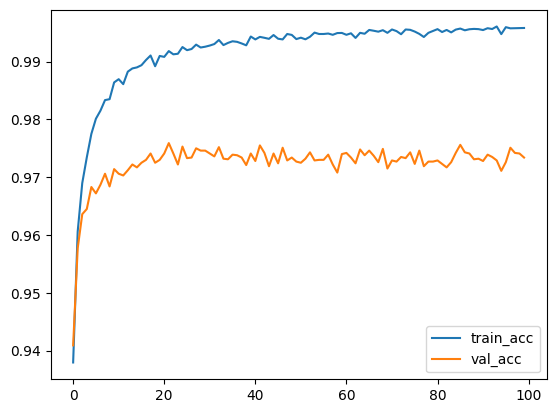

In [12]:
####################################################################################################
# enter code here to train Model2-1
input_size = data_dict['x_train'].shape[1]
num_classes = 10

model2 = PytorchNN2(input_size, hidden_size, num_classes, learning_rate)
train(model2, data_dict['x_train'], data_dict['y_train'], data_dict['x_val'], data_dict['y_val'], batch_size, epochs, learning_rate, 'cpu')
y_test2_pred = Pytorcheval(model2, data_dict['x_test'])

plt.plot(model2.history['train_acc'], label='train_acc')
plt.plot(model2.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

####################################################################################################

In [13]:
####################################################################################################
# enter code here to evaluate Model2-1
evaluator(data_dict['y_test'], y_test2_pred)

####################################################################################################

10x10 confusion matrix, ActualxPredicted for the outputs 0-9:
[[ 968.    1.    2.    1.    0.    0.    5.    1.    2.    0.]
 [   0. 1122.    2.    1.    0.    2.    4.    1.    3.    0.]
 [   4.    3. 1000.    5.    1.    1.    2.   11.    5.    0.]
 [   0.    0.    5.  980.    1.    6.    0.    7.    7.    4.]
 [   0.    2.    4.    1.  951.    0.    7.    1.    1.   15.]
 [   1.    1.    2.    5.    2.  866.    9.    1.    4.    1.]
 [   6.    2.    3.    1.    2.    3.  938.    0.    3.    0.]
 [   2.    4.    7.    2.    0.    1.    0. 1006.    1.    5.]
 [   2.    0.    4.    2.    5.    2.    1.    8.  948.    2.]
 [   2.    3.    1.    8.    7.    6.    1.    6.    8.  967.]]
Stats for each 0-9 output in increasing order:
Recall      Precision     Accuracy    F1-Score
[[0.9877551  0.9827411  0.9988     0.9852418 ]
 [0.98854625 0.9859402  0.9987     0.9872415 ]
 [0.96899223 0.9708738  0.9968     0.9699321 ]
 [0.97029704 0.97415507 0.997      0.9722222 ]
 [0.9684318  0.98142415 0

### Model2-2

In [14]:
####################################################################################################
# enter code here to implement Model2-2
class PytorchNN22(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, learning_rate):
        super(PytorchNN22, self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.sigmoid = nn.Sigmoid()

        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

####################################################################################################

epoch 1, loss 3759.9915, train acc 0.841, validation acc 0.850
epoch 2, loss 811.6757, train acc 0.938, validation acc 0.939
epoch 3, loss 447.2687, train acc 0.956, validation acc 0.954
epoch 4, loss 363.3815, train acc 0.965, validation acc 0.959
epoch 5, loss 306.7018, train acc 0.969, validation acc 0.961
epoch 6, loss 263.9392, train acc 0.972, validation acc 0.963
epoch 7, loss 231.8450, train acc 0.971, validation acc 0.961
epoch 8, loss 212.2908, train acc 0.978, validation acc 0.966
epoch 9, loss 193.7885, train acc 0.978, validation acc 0.965
epoch 10, loss 182.9007, train acc 0.979, validation acc 0.964
epoch 11, loss 174.1997, train acc 0.980, validation acc 0.967
epoch 12, loss 171.5540, train acc 0.981, validation acc 0.964
epoch 13, loss 156.4187, train acc 0.982, validation acc 0.965
epoch 14, loss 155.9614, train acc 0.984, validation acc 0.967
epoch 15, loss 145.2463, train acc 0.985, validation acc 0.968
epoch 16, loss 137.7821, train acc 0.984, validation acc 0.967


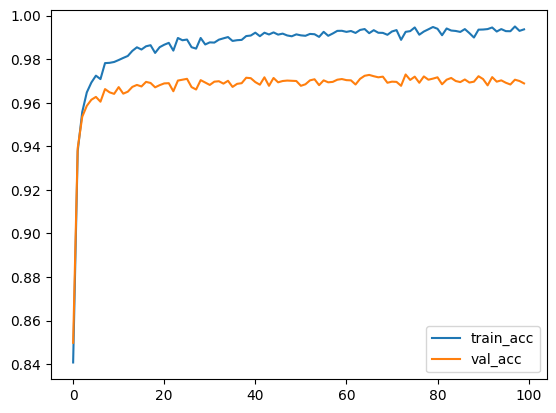

In [15]:
####################################################################################################
# enter code here to train Model2-2
input_size = data_dict['x_train'].shape[1]
num_classes = 10
hidden_size1 = 128
hidden_size2 = 64

model22 = PytorchNN22(input_size, hidden_size1, hidden_size2, num_classes, learning_rate)
train(model22, data_dict['x_train'], data_dict['y_train'], data_dict['x_val'], data_dict['y_val'], batch_size, epochs, learning_rate, 'cpu')
y_test2_pred = Pytorcheval(model22, data_dict['x_test'])
plt.plot(model22.history['train_acc'], label='train_acc')
plt.plot(model22.history['val_acc'], label='val_acc')
plt.legend()
plt.show()
####################################################################################################

In [16]:
####################################################################################################
# enter code here to evaluate Model2-2
evaluator(data_dict['y_test'], y_test2_pred)

####################################################################################################

10x10 confusion matrix, ActualxPredicted for the outputs 0-9:
[[ 958.    0.    2.    1.    2.    2.    9.    1.    5.    0.]
 [   0. 1121.    5.    0.    0.    2.    4.    1.    2.    0.]
 [   0.    0. 1008.    3.    0.    0.    3.    5.   13.    0.]
 [   0.    1.   11.  978.    0.    8.    0.    6.    5.    1.]
 [   1.    0.    2.    0.  958.    0.    7.    2.    2.   10.]
 [   3.    0.    0.   13.    0.  852.   13.    1.    6.    4.]
 [   3.    2.    0.    1.    3.    2.  944.    0.    2.    1.]
 [   1.    4.   12.    2.    3.    1.    0.  998.    2.    5.]
 [   3.    0.    9.    7.    4.    6.    5.    4.  936.    0.]
 [   4.    2.    0.   11.   21.    6.    3.   11.   11.  940.]]
Stats for each 0-9 output in increasing order:
Recall      Precision     Accuracy    F1-Score
[[0.97755104 0.98458374 0.9978     0.9810547 ]
 [0.9876652  0.9920354  0.9986     0.98984545]
 [0.9767442  0.96091515 0.9976     0.9687651 ]
 [0.96831685 0.96259844 0.9968     0.96544915]
 [0.97556007 0.9667003  0